# Import 

In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

project_id = 'royal-hexa-in-house'

from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client(project=project_id)

# EDA 

In [36]:
query = """ 
select distinct user_pseudo_id, level, day from `royal-hexa-in-house.dung_dinner_flatten.level_end_day`
where level is not null and day is not null
and user_pseudo_id in 
(select distinct user_pseudo_id from `royal-hexa-in-house.dung_dinner_flatten.first_open` where event_date between '2025-03-15' and '2025-03-30')
"""
end_day = client.query(query).to_dataframe()
end_day

c:\Users\dungv\Downloads\Adone_Trainning\DS06\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,user_pseudo_id,level,day
0,e7f3b4af8adf777af1d13c944dde4583,29,3
1,5d8323874cb99631c404cc1b91a68fa0,58,30
2,becb6286dcd45de28d7afe230308cf6e,28,14
3,887ff26e0fa53d65b66952c67bc4d2ca,29,25
4,f4b88552de29a2877b842f83908c4150,41,30
...,...,...,...
194741,f8d0f86fd46a725ad496a6790b476a56,25,13
194742,6462db42385ad92020cd09b07333f03c,25,6
194743,84f80405307f483aff18ab7b88be4ebb,25,7
194744,387d1805c0c70f20986adbb4624c36e7,25,1


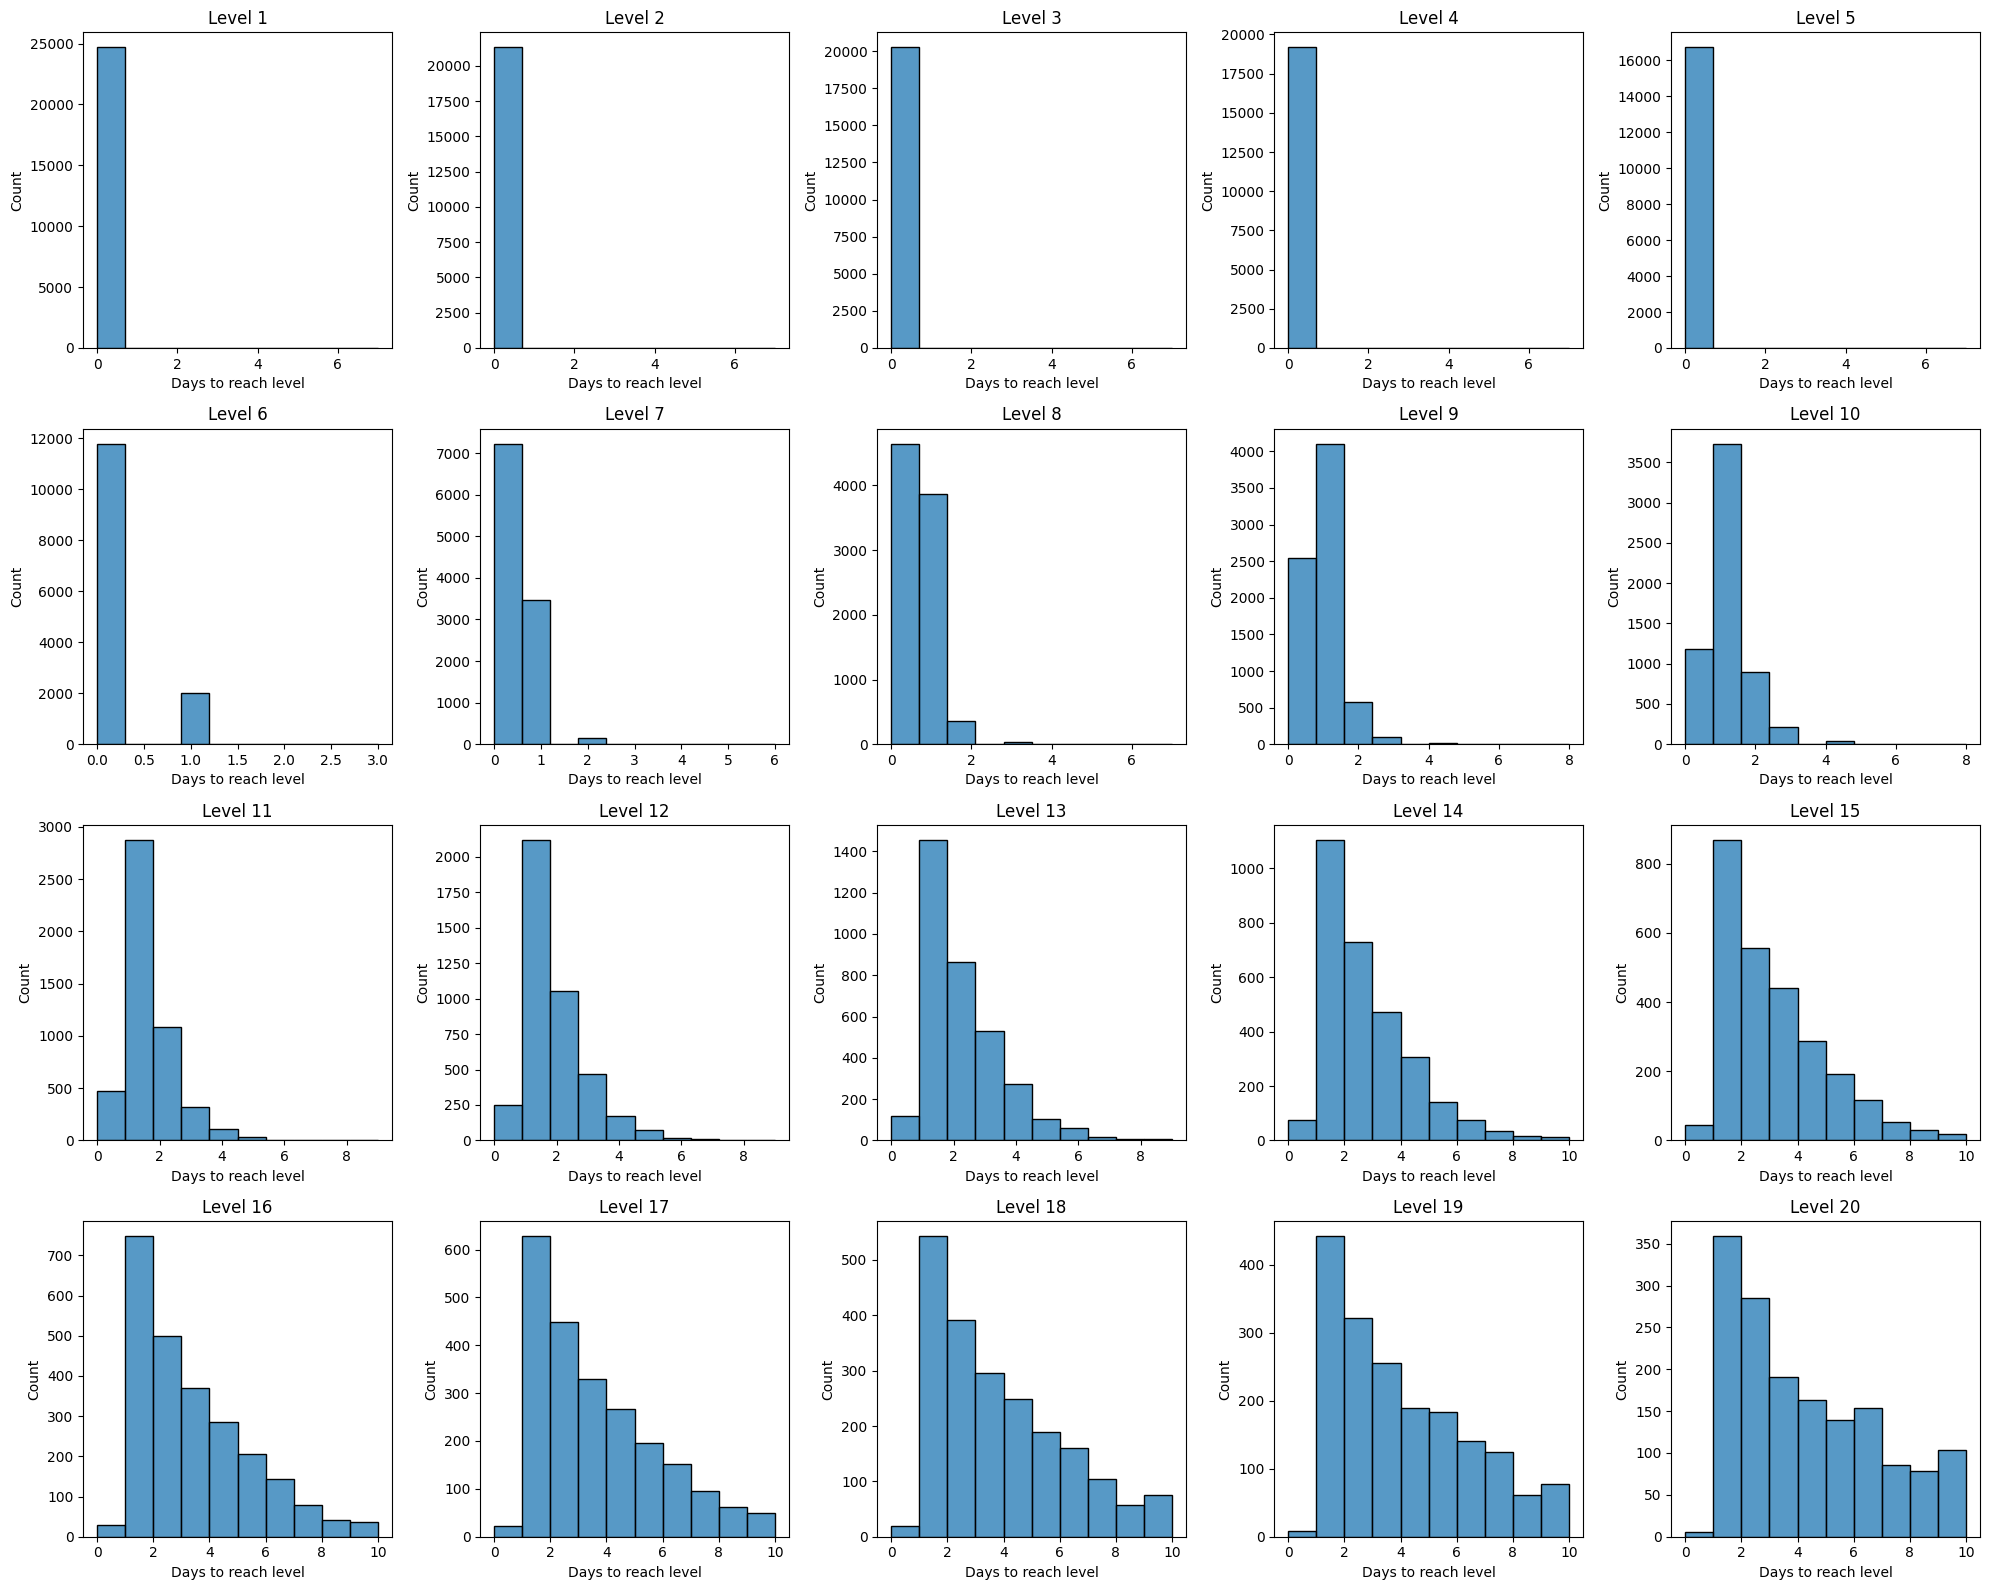

In [37]:
# Create a figure with 20 subplots arranged in 4x5 grid
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

# Get unique levels up to 20 and filter for days <= 10
filtered_data = end_day[end_day['day'] <= 10]
levels = sorted(filtered_data['level'].unique())[:20]  # Take first 20 levels

# Create histogram for each level
for i, level in enumerate(levels):
    level_data = filtered_data[filtered_data['level'] == level]['day']
    
    sns.histplot(data=level_data, bins=10, ax=axes[i])
    axes[i].set_title(f'Level {level}')
    axes[i].set_xlabel('Days to reach level')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

Nhận thấy rằng đa phần user đều có thể hoàn thành level 6 trong d0.
Vì vậy ta có thể lấy mốc dễ nhất để segment là d0: 
- Nhóm 1: User hoàn thành được level 6
- Nhóm 2: User không hoàn thành được level 6

In [38]:
# Số lượng 2 nhóm 
# Count users who completed level 6 on day 0 vs after day 0
level_6_users = end_day[end_day['level'] == 6].groupby('day')['user_pseudo_id'].nunique()

print("Users completing level 6:")
print(f"On day 0: {level_6_users.get(0, 0):,}")
print(f"After day 0: {level_6_users[level_6_users.index > 0].sum():,}")

Users completing level 6:
On day 0: 11,783
After day 0: 2,052


Chênh lệch 2 nhóm quá lớn, việc segment để đối xử với 10% user cảm thấy không hiệu quả

Tiếp theo ta sẽ lấy ra số lượng user chỉ hoàn thành đúng level đó trong d0 sau đó dừng lại(ví dụ có event end level 6 tại d0 thì phải ko có event end level 7 tại d0 thì mới được tính)

In [39]:
# Get users who completed each level exactly on day 0 and didn't progress further that day
level_counts = []
level_labels = []


# Handle levels 6-8 individually
for level in range(6, 9):
    # Get users who completed this level on day 0
    users_at_level = end_day[
        (end_day['level'] == level) & 
        (end_day['day'] == 0)
    ]['user_pseudo_id'].unique()
    
    # Exclude users who completed higher levels on day 0
    users_at_higher_levels = end_day[
        (end_day['level'] > level) & 
        (end_day['day'] == 0)
    ]['user_pseudo_id'].unique()
    
    # Get users who ONLY completed this level on day 0
    final_users = set(users_at_level) - set(users_at_higher_levels)
    
    level_counts.append(len(final_users))
    level_labels.append(level)

# Handle level 9 and above as one group
users_at_high_level = end_day[
    (end_day['level'] >= 9) & 
    (end_day['day'] == 0)
]['user_pseudo_id'].unique()

level_counts.append(len(users_at_high_level))
level_labels.append('>=9')

# Create a summary dataframe
summary_df = pd.DataFrame({
    'level': level_labels,
    'users_completed_d0': level_counts
})

print("Number of users who completed each level on day 0 and stopped:")
display(summary_df)

Number of users who completed each level on day 0 and stopped:


,level,users_completed_d0
0,6,4569
1,7,2582
2,8,2109
3,>=9,2562


 Được 4 nhóm: 
- Hoàn thành level 6 trong d0 (xong stop) 
- Hoàn thành level 7 trong d0 (xong stop) 
- Hoàn thành level 8 trong d0 (xong stop) 
- Hoàn thành > level 9 trong d0 (xong stop hoặc là ko) 






In [41]:
# Get users who completed each level exactly on day 0 and didn't progress further that day
# Initialize series to store user IDs for each group
users_level_6 = pd.Series(dtype='object') 
users_level_7 = pd.Series(dtype='object')
users_level_8 = pd.Series(dtype='object')
users_level_9_plus = pd.Series(dtype='object')

# Handle levels 6-8 individually
for level in range(6, 9):
    # Get users who completed this level on day 0
    users_at_level = end_day[
        (end_day['level'] == level) & 
        (end_day['day'] == 0)
    ]['user_pseudo_id'].unique()
    
    # Exclude users who completed higher levels on day 0
    users_at_higher_levels = end_day[
        (end_day['level'] > level) & 
        (end_day['day'] == 0)
    ]['user_pseudo_id'].unique()
    
    # Get users who ONLY completed this level on day 0
    final_users = set(users_at_level) - set(users_at_higher_levels)
    
    # Store users in appropriate series
    if level == 6:
        users_level_6 = pd.Series(list(final_users))
    elif level == 7:
        users_level_7 = pd.Series(list(final_users))
    elif level == 8:
        users_level_8 = pd.Series(list(final_users))

# Handle level 9 and above as one group
users_level_9_plus = pd.Series(end_day[
    (end_day['level'] >= 9) & 
    (end_day['day'] == 0)
]['user_pseudo_id'].unique())

print("Number of users in each group:")
print(f"Level 6: {len(users_level_6)}")
print(f"Level 7: {len(users_level_7)}")
print(f"Level 8: {len(users_level_8)}")
print(f"Level >=9: {len(users_level_9_plus)}")

Number of users in each group:
Level 6: 4569
Level 7: 2582
Level 8: 2109
Level >=9: 2562


### Compare 4 segment 

c:\Users\dungv\Downloads\Adone_Trainning\DS06\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


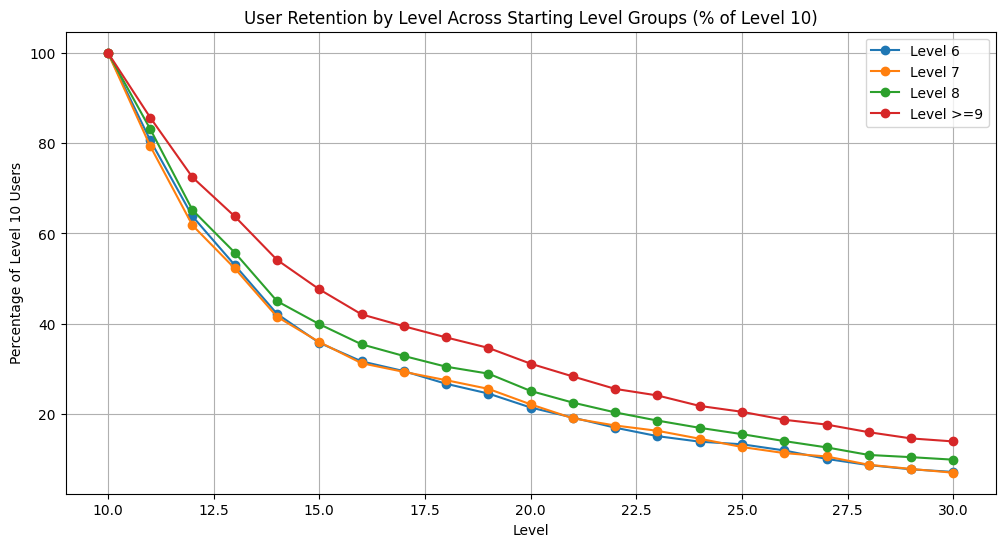

In [42]:
query = f"""
SELECT
    level,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(users_level_6)}) THEN user_pseudo_id END) as users_level_6,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(users_level_7)}) THEN user_pseudo_id END) as users_level_7,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(users_level_8)}) THEN user_pseudo_id END) as users_level_8,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST({list(users_level_9_plus)}) THEN user_pseudo_id END) as users_level_9_plus
FROM
    `royal-hexa-in-house.dung_dinner_flatten.start_level`
WHERE level between 10 and 30 
GROUP BY level
ORDER BY level;
"""

drop_by_level = client.query(query).to_dataframe()

# Calculate percentages relative to level 10 for each user group
level10_users_6 = drop_by_level[drop_by_level['level']==10]['users_level_6'].values[0]
level10_users_7 = drop_by_level[drop_by_level['level']==10]['users_level_7'].values[0]
level10_users_8 = drop_by_level[drop_by_level['level']==10]['users_level_8'].values[0]
level10_users_9_plus = drop_by_level[drop_by_level['level']==10]['users_level_9_plus'].values[0]

drop_by_level['pct_level_6'] = drop_by_level['users_level_6'] / level10_users_6 * 100
drop_by_level['pct_level_7'] = drop_by_level['users_level_7'] / level10_users_7 * 100
drop_by_level['pct_level_8'] = drop_by_level['users_level_8'] / level10_users_8 * 100
drop_by_level['pct_level_9_plus'] = drop_by_level['users_level_9_plus'] / level10_users_9_plus * 100

# Define colors for user groups
level_colors = {
    'Level 6': '#1f77b4',    # Blue
    'Level 7': '#ff7f0e',    # Orange
    'Level 8': '#2ca02c',    # Green
    'Level >=9': '#d62728'   # Red
}

# Plot percentages for levels 10-30
plt.figure(figsize=(12, 6))
plt.plot(drop_by_level['level'], drop_by_level['pct_level_6'], 
         marker='o', label='Level 6', color=level_colors['Level 6'])
plt.plot(drop_by_level['level'], drop_by_level['pct_level_7'],
         marker='o', label='Level 7', color=level_colors['Level 7'])
plt.plot(drop_by_level['level'], drop_by_level['pct_level_8'],
         marker='o', label='Level 8', color=level_colors['Level 8'])
plt.plot(drop_by_level['level'], drop_by_level['pct_level_9_plus'],
         marker='o', label='Level >=9', color=level_colors['Level >=9'])

plt.xlabel('Level')
plt.ylabel('Percentage of Level 10 Users')
plt.title('User Retention by Level Across Starting Level Groups (% of Level 10)')
plt.legend()
plt.grid(True)
plt.show()

Cái này đương nhiên là như này rồi

c:\Users\dungv\Downloads\Adone_Trainning\DS06\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


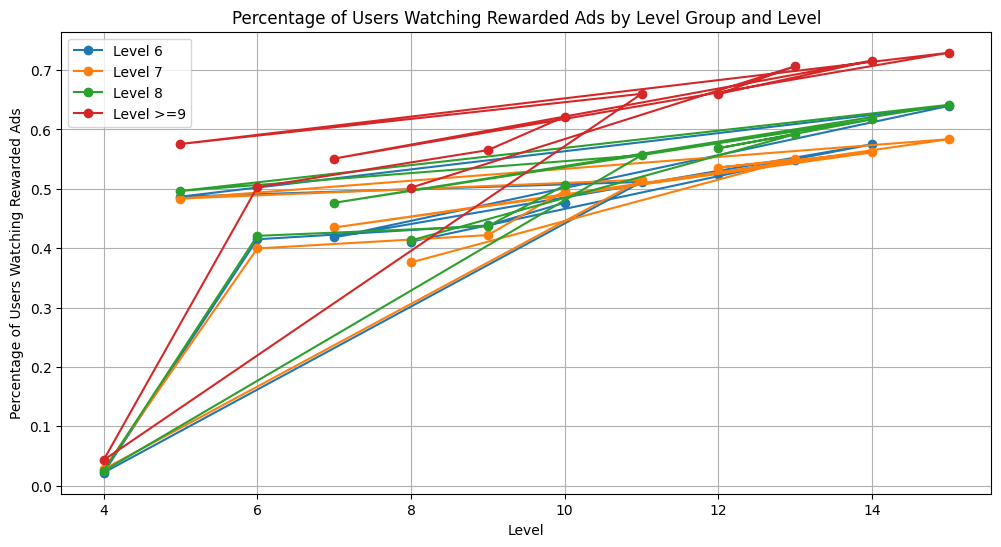

In [ ]:
# Ad rw 
query = f"""
WITH START AS (
SELECT
    level,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_6]) + """]) THEN user_pseudo_id END) as start_level_6,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_7]) + """]) THEN user_pseudo_id END) as start_level_7,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_8]) + """]) THEN user_pseudo_id END) as start_level_8,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_9_plus]) + """]) THEN user_pseudo_id END) as start_level_9_plus
FROM
    `royal-hexa-in-house.dung_dinner_flatten.start_level`
GROUP BY level
ORDER BY level
),
AD AS (
SELECT
    level,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_6]) + """]) THEN user_pseudo_id END) as user_rewarded_level_6,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_7]) + """]) THEN user_pseudo_id END) as user_rewarded_level_7,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_8]) + """]) THEN user_pseudo_id END) as user_rewarded_level_8,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_9_plus]) + """]) THEN user_pseudo_id END) as user_rewarded_level_9_plus
FROM
    `royal-hexa-in-house.dung_dinner_flatten.af_rewarded`
GROUP BY level
ORDER BY level
)
SELECT s.level, 
       SAFE_DIVIDE(a.user_rewarded_level_6, s.start_level_6) as pct_user_rewarded_level_6,
       SAFE_DIVIDE(a.user_rewarded_level_7, s.start_level_7) as pct_user_rewarded_level_7,
       SAFE_DIVIDE(a.user_rewarded_level_8, s.start_level_8) as pct_user_rewarded_level_8,
       SAFE_DIVIDE(a.user_rewarded_level_9_plus, s.start_level_9_plus) as pct_user_rewarded_level_9_plus
FROM START s
JOIN AD a
ON s.level = a.level
where s.level between 4 and 15
"""


c:\Users\dungv\Downloads\Adone_Trainning\DS06\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


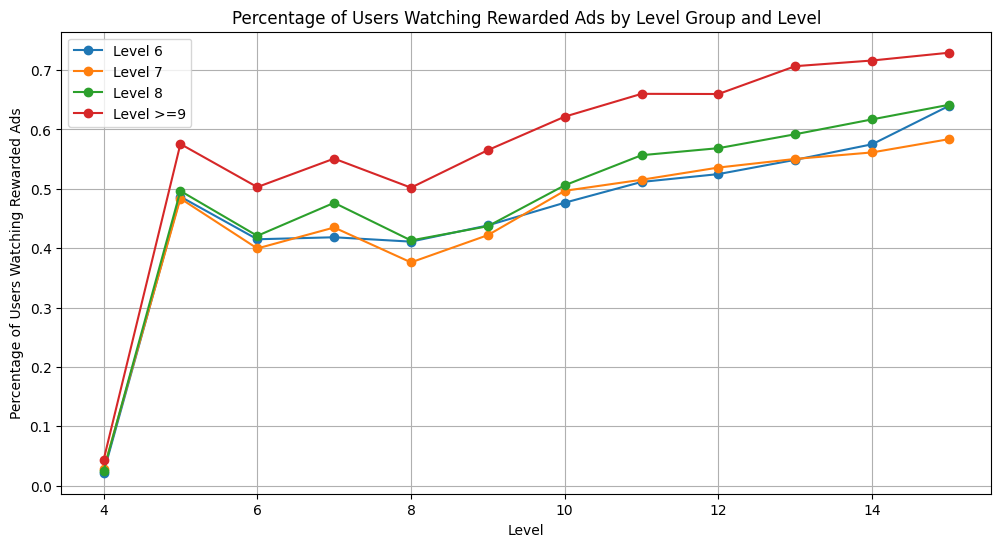

In [50]:
user_rewarded_by_level = client.query(query).to_dataframe()
user_rewarded_by_level.sort_values(by='level', inplace=True)

plt.figure(figsize=(12, 6))

plt.plot(user_rewarded_by_level.level, user_rewarded_by_level.pct_user_rewarded_level_6, marker='o', label='Level 6', color=level_colors['Level 6'])
plt.plot(user_rewarded_by_level.level, user_rewarded_by_level.pct_user_rewarded_level_7, marker='o', label='Level 7', color=level_colors['Level 7'])
plt.plot(user_rewarded_by_level.level, user_rewarded_by_level.pct_user_rewarded_level_8, marker='o', label='Level 8', color=level_colors['Level 8'])
plt.plot(user_rewarded_by_level.level, user_rewarded_by_level.pct_user_rewarded_level_9_plus, marker='o', label='Level >=9', color=level_colors['Level >=9'])
                
plt.xlabel('Level')
plt.ylabel('Percentage of Users Watching Rewarded Ads')
plt.title('Percentage of Users Watching Rewarded Ads by Level Group and Level')
plt.legend()
plt.grid(True)
plt.show()

User càng chơi nhiều level trong d0 thì là user yêu thích game, xem nhiều ads

c:\Users\dungv\Downloads\Adone_Trainning\DS06\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


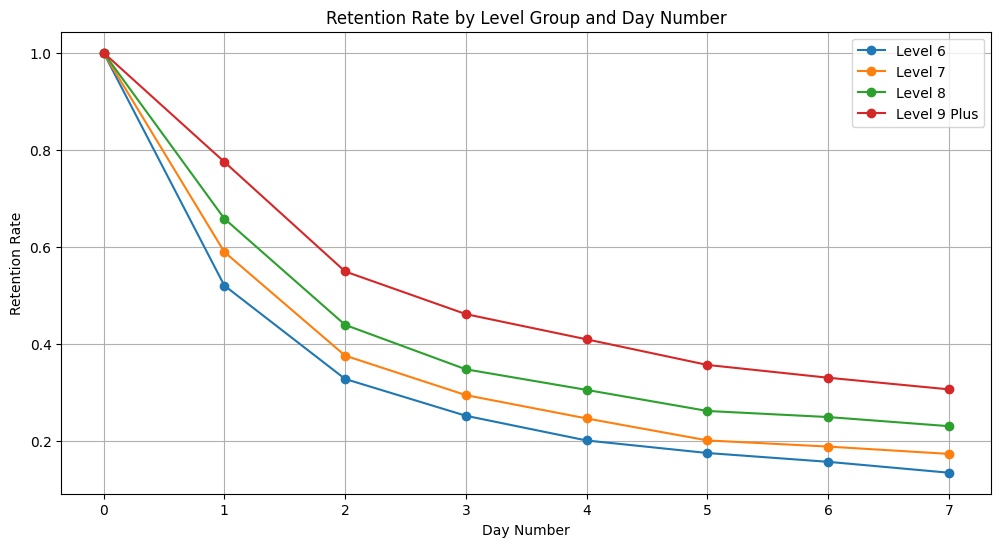

In [51]:
query = """ 
WITH user_groups AS (
  SELECT 
    user_pseudo_id,
    CASE 
      WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_6]) + """]) THEN 'level_6'
      WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_7]) + """]) THEN 'level_7'
      WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_8]) + """]) THEN 'level_8'
      WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_9_plus]) + """]) THEN 'level_9_plus'
    END as user_group
  FROM `royal-hexa-in-house.dung_dinner_flatten.first_open`
  GROUP BY 1
),
first_open_dates AS (
  SELECT 
    user_pseudo_id,
    MIN(event_date) as first_open_date
  FROM `royal-hexa-in-house.dung_dinner_flatten.first_open`
  WHERE user_pseudo_id IN (SELECT user_pseudo_id FROM user_groups WHERE user_group IS NOT NULL)
  GROUP BY 1
),
engagement AS (
  SELECT DISTINCT user_pseudo_id, event_date 
  FROM `royal-hexa-in-house.dung_dinner_flatten.user_engagement`
),
retention_data AS (
  SELECT
    g.user_group,
    f.user_pseudo_id,
    f.first_open_date,
    e.event_date,
    DATE_DIFF(e.event_date, f.first_open_date, DAY) as day_number
  FROM first_open_dates f
  JOIN user_groups g ON f.user_pseudo_id = g.user_pseudo_id
  LEFT JOIN engagement e ON f.user_pseudo_id = e.user_pseudo_id
  WHERE DATE_DIFF(e.event_date, f.first_open_date, DAY) BETWEEN 0 AND 7
)
SELECT
  user_group,
  day_number,
  COUNT(DISTINCT user_pseudo_id) as retained_users
FROM retention_data
GROUP BY 1, 2
ORDER BY 1, 2
"""

retention_by_group = client.query(query).to_dataframe()

# Calculate retention rates for each group
groups = ['level_6', 'level_7', 'level_8', 'level_9_plus']
retention_rates = pd.DataFrame()

for group in groups:
    group_data = retention_by_group[retention_by_group['user_group'] == group].copy()
    day0_users = group_data.loc[group_data['day_number']==0, 'retained_users'].iloc[0]
    group_data['retention_rate'] = group_data['retained_users'] / day0_users
    retention_rates = pd.concat([retention_rates, group_data])

# Plot retention rates
plt.figure(figsize=(12,6))
for group in groups:
    group_data = retention_rates[retention_rates['user_group'] == group]
    plt.plot(group_data['day_number'], group_data['retention_rate'], 
             label=group.replace('_', ' ').title(), 
             marker='o',
             color=level_colors['Level ' + group.split('_')[-1].replace('plus', '>=9')])

plt.xlabel('Day Number')
plt.ylabel('Retention Rate')
plt.title('Retention Rate by Level Group and Day Number')
plt.grid(True)
plt.legend()
plt.show()

User càng chơi nhiều level trong d0 thì là user yêu thích game, ở lại game tốt theo từng ngày 


c:\Users\dungv\Downloads\Adone_Trainning\DS06\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


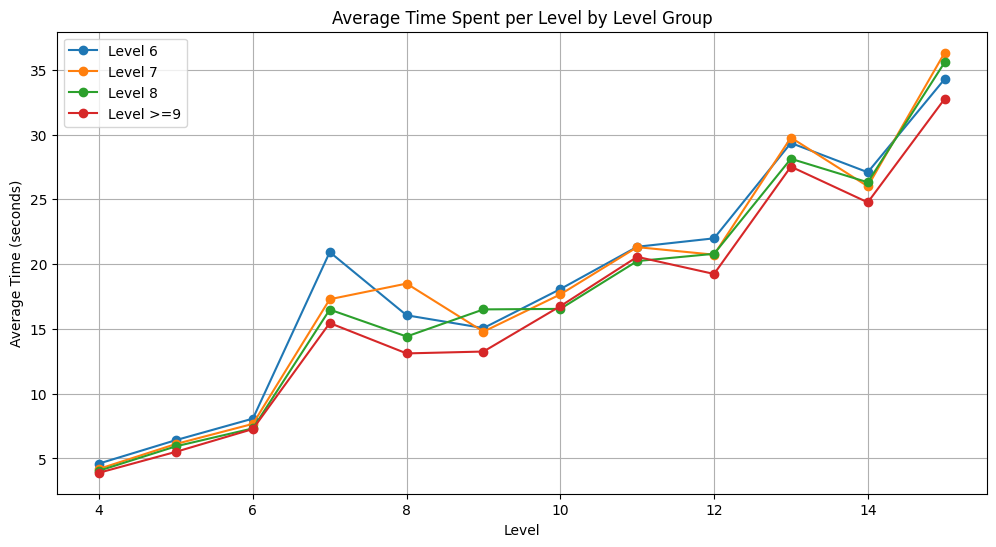

In [54]:
# Time per level
query = f"""
WITH START AS (
SELECT
    level,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_6]) + """]) THEN user_pseudo_id END) as start_level_6,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_7]) + """]) THEN user_pseudo_id END) as start_level_7,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_8]) + """]) THEN user_pseudo_id END) as start_level_8,
    COUNT(DISTINCT CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_9_plus]) + """]) THEN user_pseudo_id END) as start_level_9_plus
FROM
    `royal-hexa-in-house.dung_dinner_flatten.start_level`
GROUP BY level
ORDER BY level
),
TIME_LEVEL AS (
SELECT
    level,
    AVG(CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_6]) + """]) THEN time_minute END) as avg_time_level_6,
    AVG(CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_7]) + """]) THEN time_minute END) as avg_time_level_7,
    AVG(CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_8]) + """]) THEN time_minute END) as avg_time_level_8,
    AVG(CASE WHEN user_pseudo_id IN UNNEST([""" + ','.join([f"'{u}'" for u in users_level_9_plus]) + """]) THEN time_minute END) as avg_time_level_9_plus
FROM
    `royal-hexa-in-house.dung_dinner_flatten.level_time`
GROUP BY level
ORDER BY level
)
SELECT s.level,
       t.avg_time_level_6,
       t.avg_time_level_7, 
       t.avg_time_level_8,
       t.avg_time_level_9_plus
FROM START s
JOIN TIME_LEVEL t
ON s.level = t.level
WHERE s.level between 4 and 15
"""
time_per_level = client.query(query).to_dataframe()
time_per_level.sort_values(by='level', inplace=True)

plt.figure(figsize=(12, 6))

plt.plot(time_per_level.level, time_per_level.avg_time_level_6, marker='o', label='Level 6', color=level_colors['Level 6'])
plt.plot(time_per_level.level, time_per_level.avg_time_level_7, marker='o', label='Level 7', color=level_colors['Level 7'])
plt.plot(time_per_level.level, time_per_level.avg_time_level_8, marker='o', label='Level 8', color=level_colors['Level 8'])
plt.plot(time_per_level.level, time_per_level.avg_time_level_9_plus, marker='o', label='Level >=9', color=level_colors['Level >=9'])
                
plt.xlabel('Level')
plt.ylabel('Average Time (seconds)')
plt.title('Average Time Spent per Level by Level Group')
plt.legend()
plt.grid(True)
plt.show()

Level 9 time chơi ngắn hơn user level 8 và ngắn hơn 6 + 7. Tệp user hoàn thành level 6 và level 7 khá giống nhau trong nhiều trường hợp